In [1]:
is_cuda = False

In [2]:
# for colab 
# !pip install pyro-ppl==0.4.1
# is_cuda = True

In [2]:
from models.NB import NeB
from models.Poisson import Pois
from models.mlrModel import MlrModel
from preprocessor import YelpData,load,to_pickle
from inference import svi, mcmc
from criticism import svi_posterior, mcmc_posterior, mlr_sampling
from plot import plot_loss, plot_count_dist, plot_data_heatmap, plot_rating_dist, plot_beta_value
import criticism, inference

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.distributions import constraints
import pyro
import pyro.optim as optim
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, JitTrace_ELBO, TracePredictive, TraceEnum_ELBO,config_enumerate
import pyro.distributions as dist
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
from pyro.infer.autoguide import init_to_feasible



In [3]:
sns.set()
if_load = True


Data setup

In [4]:
if if_load:
    data_class = YelpData()
    data = load('data_pickle/data')
    ratings = load('data_pickle/ratings')
    rest_data = load('data_pickle/rest_data')
else:
# only for first time 
    data_class.process()
    data = torch.from_numpy(data_class.add_bias().astype(np.float32))
    ratings = torch.from_numpy(data_class.ratings.to_numpy().astype(np.float32))
    to_pickle(data, 'data_pickle/data')
    to_pickle(ratings, 'data_pickle/ratings')
    to_pickle(data_class.rest_data, 'data_pickle/rest_data')
train_ratings = (ratings - 1)*2

In [5]:
if is_cuda:
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    data = data.cuda()
    ratings = ratings.cuda()
    train_ratings = train_ratings.cuda()

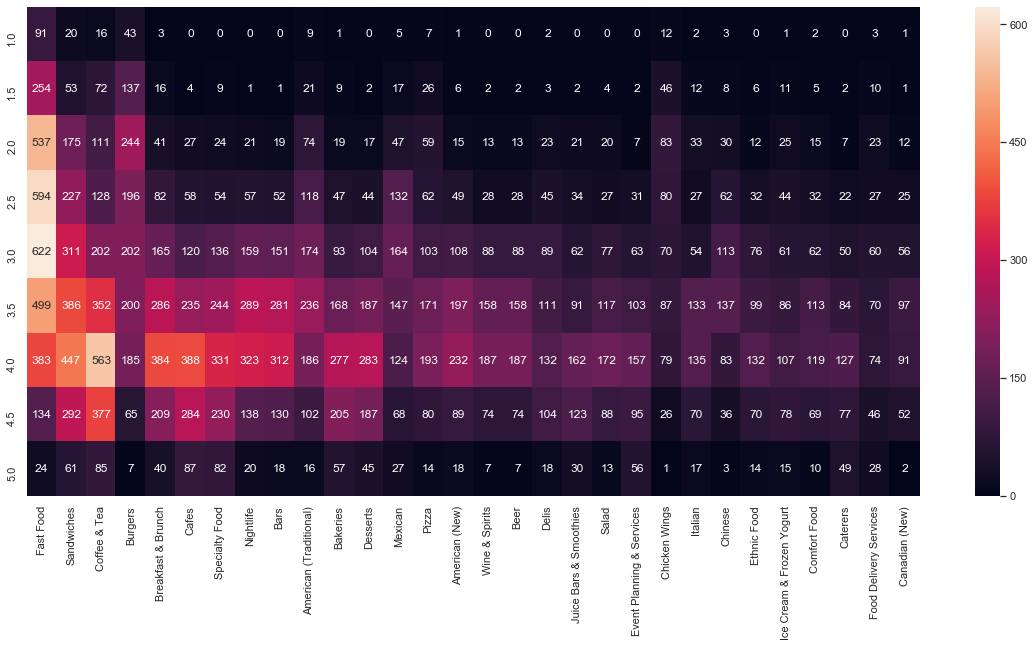

In [6]:
plot_data_heatmap(rest_data)

Model: Multinomial Logistic Regression

In [7]:
mlrmodel = MlrModel()

In [8]:
# not load model data
if_load = False

Inference: SVI

In [17]:
if if_load == False:
  # from pyro.infer.autoguide import AutoDiagonalNormal
  # guide = AutoDiagonalNormal(mlrmodel.model)

    mlr_svi_model, mlr_loss_list = \
    svi(data, train_ratings, mlrmodel.model, mlrmodel.guide, 10000, "mlr", if_save = True, if_print = True)
else:
    mlr_loss_list = load("data_pickle/mlr_svi_loss")

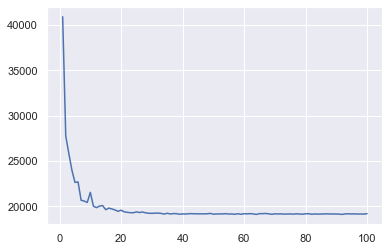

In [18]:
plot_loss(mlr_loss_list)

Critisim: SVI

In [19]:
if if_load == False:
    mlr_svi_betas = svi_posterior(mlr_svi_model, data, train_ratings, mlrmodel.model, "mlr", if_save=True)
else:
    mlr_svi_betas = load("data_pickle/mlr_svi_beta_dict")

In [20]:
if is_cuda == True:
    marginal_svi = \
                  mlr_sampling({k: torch.from_numpy(v).cuda() for k,v in mlr_svi_betas.items()}, \
                  data, "svi", if_save = True, is_cuda=True)
else:
    marginal_svi = mlr_sampling(mlr_svi_betas, data, "svi", if_save = True, is_cuda = False )

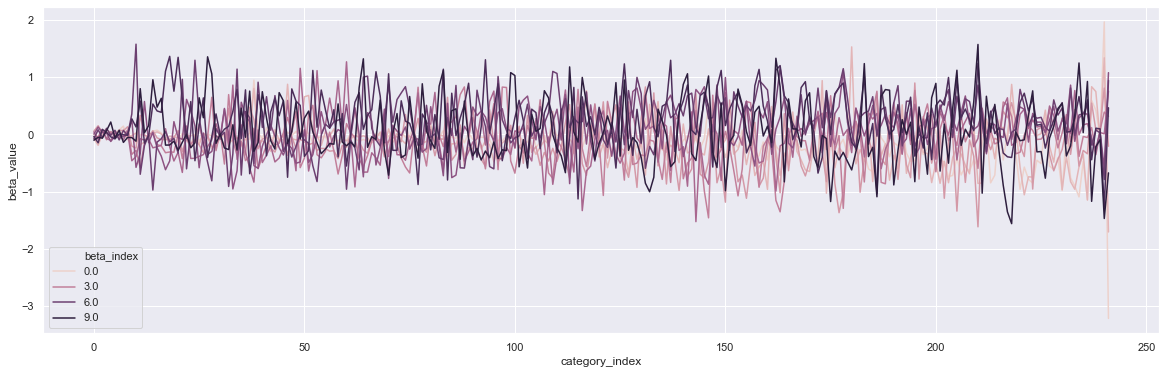

In [21]:
plot_beta_value(mlr_svi_betas)

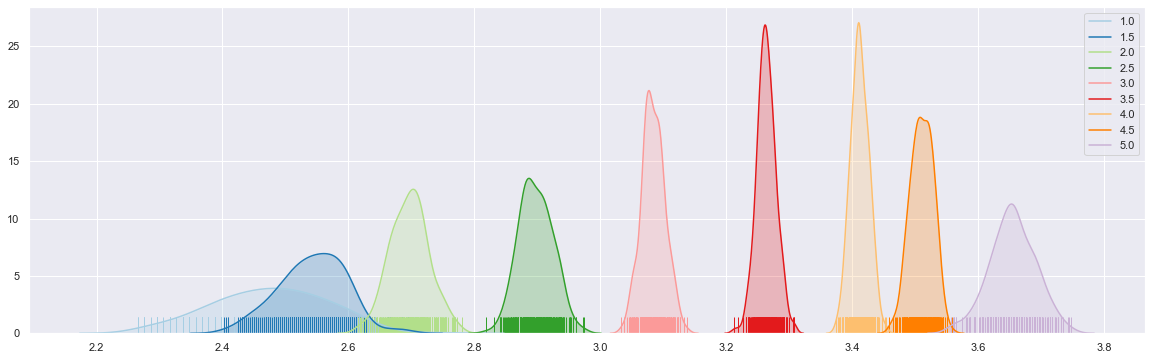

In [22]:
if is_cuda:
    train_ratings_np = train_ratings.detach().cpu().numpy()
    plot_rating_dist(marginal_svi.detach().cpu().numpy(),train_ratings_np)
else:
    plot_rating_dist(marginal_svi, train_ratings)

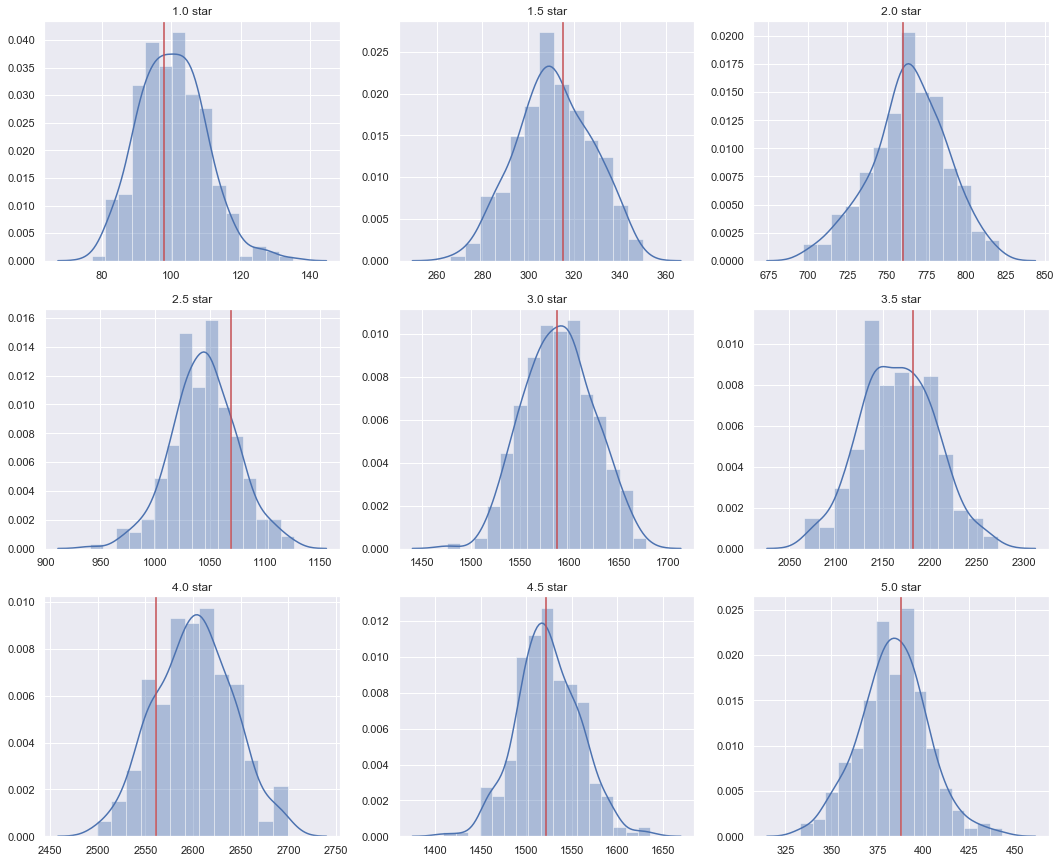

In [24]:
plot_count_dist(marginal_svi,train_ratings,is_cuda = is_cuda)

Inference: MCMC

In [25]:
if if_load == False:
    mlr_mcmc = mcmc(data, train_ratings, mlrmodel.model, "mlr", if_save=True)
else:
    mlr_mcmc = load("data_pickle/mlr_mcmc_model")

Critisim: SVI

In [33]:
if if_load == False:
    mlr_mcmc_betas = mcmc_posterior(mlr_mcmc, data, train_ratings, "mlr", if_save=True, is_cuda=is_cuda)
else:
    mlr_mcmc_betas = load("data_pickle/mlr_mcmc_beta_dict")

In [34]:
if is_cuda == True:
    marginal_mcmc = \
                  mlr_sampling({k: torch.from_numpy(v).cuda() for k,v in mlr_mcmc_betas.items()}, \
                  data, "mcmc", if_save = True, is_cuda=True)
else:
    marginal_mcmc = mlr_sampling(mlr_mcmc_betas, data, "mcmc", if_save = True, is_cuda = False )

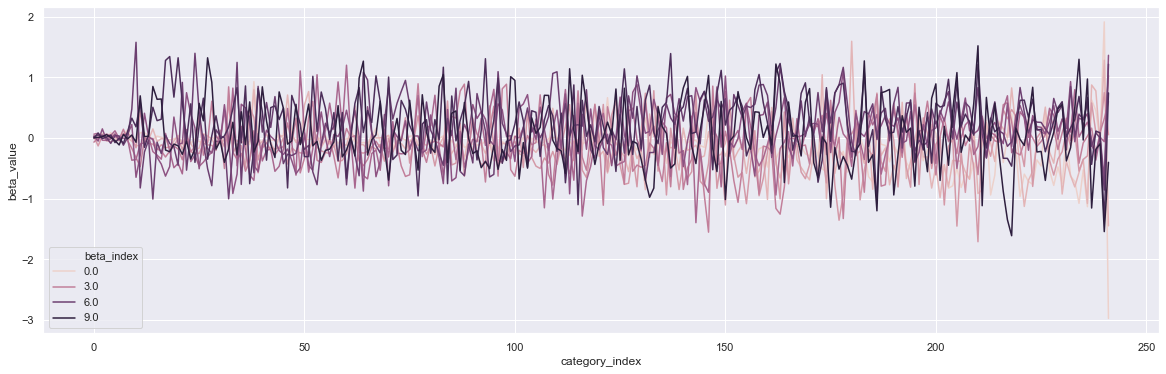

In [35]:
plot_beta_value(mlr_mcmc_betas)

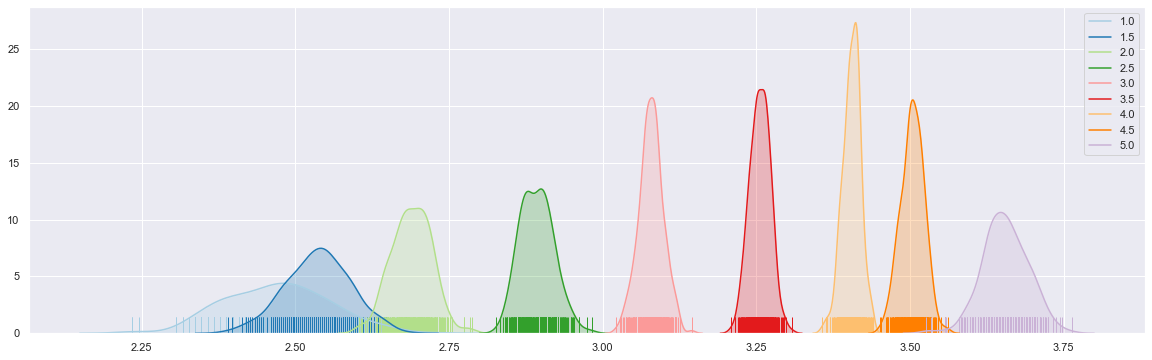

In [36]:
if is_cuda:
    train_ratings_np = train_ratings.detach().cpu().numpy()
    plot_rating_dist(marginal_mcmc.detach().cpu().numpy(),train_ratings_np)
else:
    plot_rating_dist(marginal_mcmc, train_ratings)

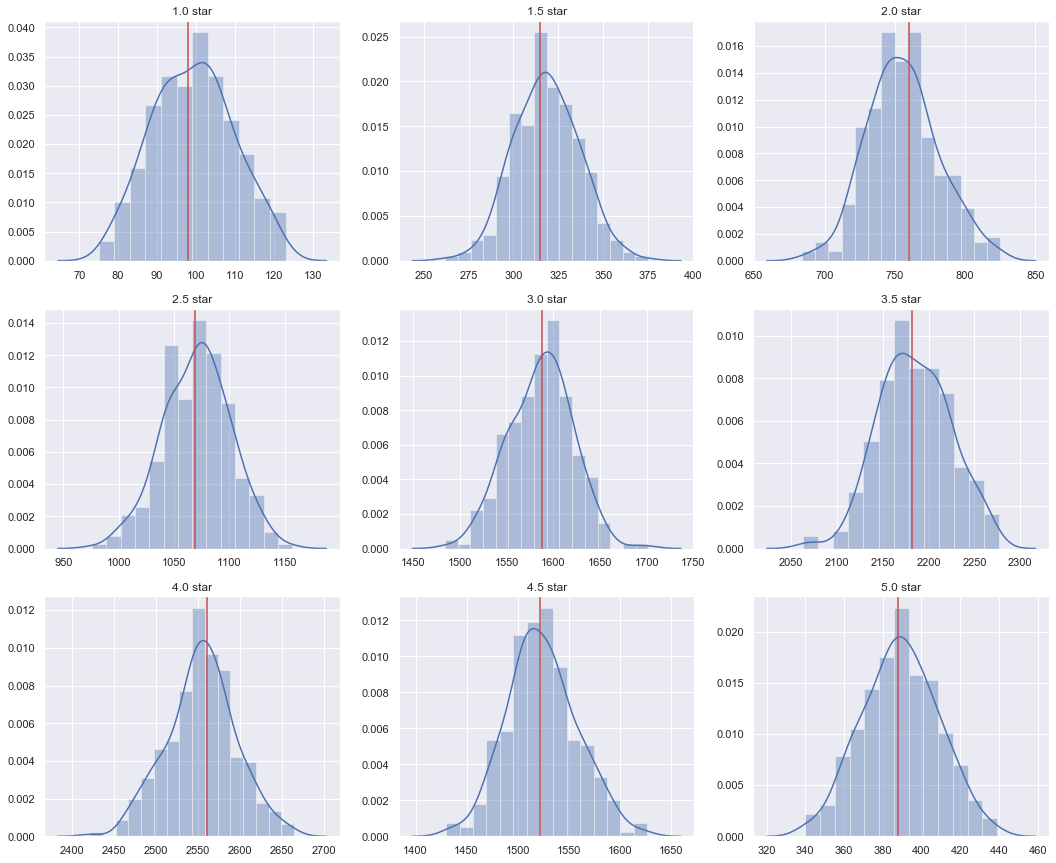

In [38]:
plot_count_dist(marginal_mcmc,train_ratings,is_cuda = is_cuda)

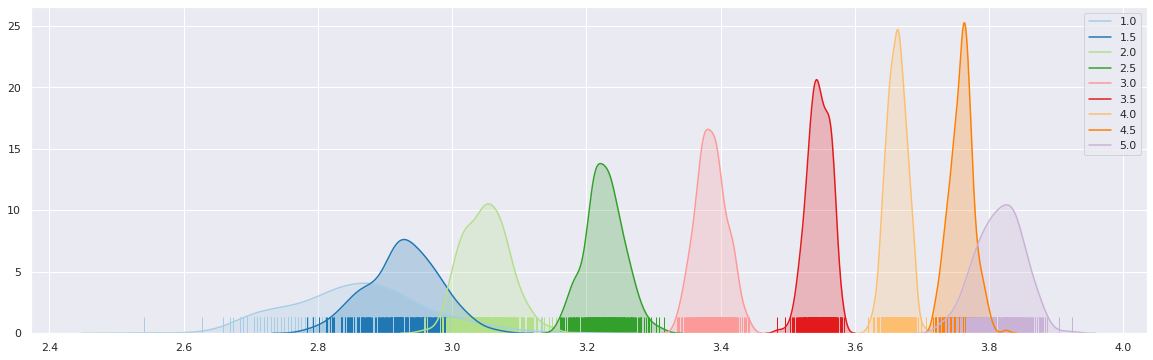

In [10]:
train_ratings_np = train_ratings.detach().cpu().numpy()
plot_rating_dist(marginal_svi.detach().cpu().numpy(),train_ratings_np)

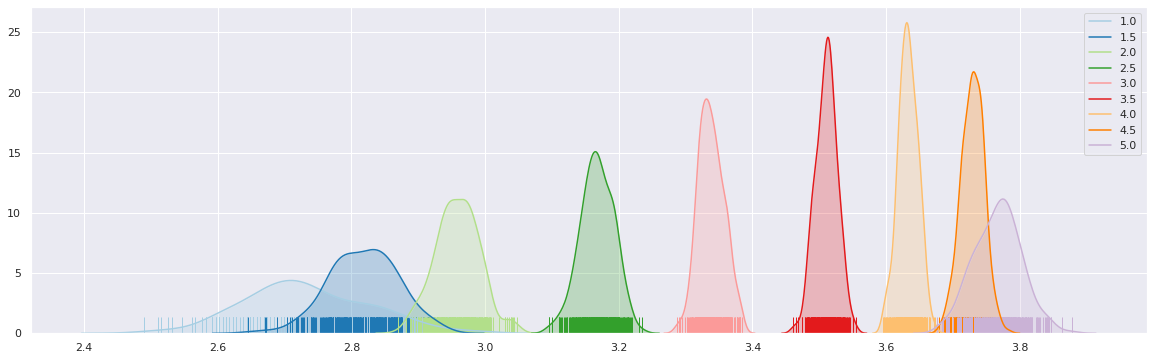

In [9]:
train_ratings_np = train_ratings.detach().cpu().numpy()
plot_rating_dist(marginal_mcmc.detach().cpu().numpy(),train_ratings_np)

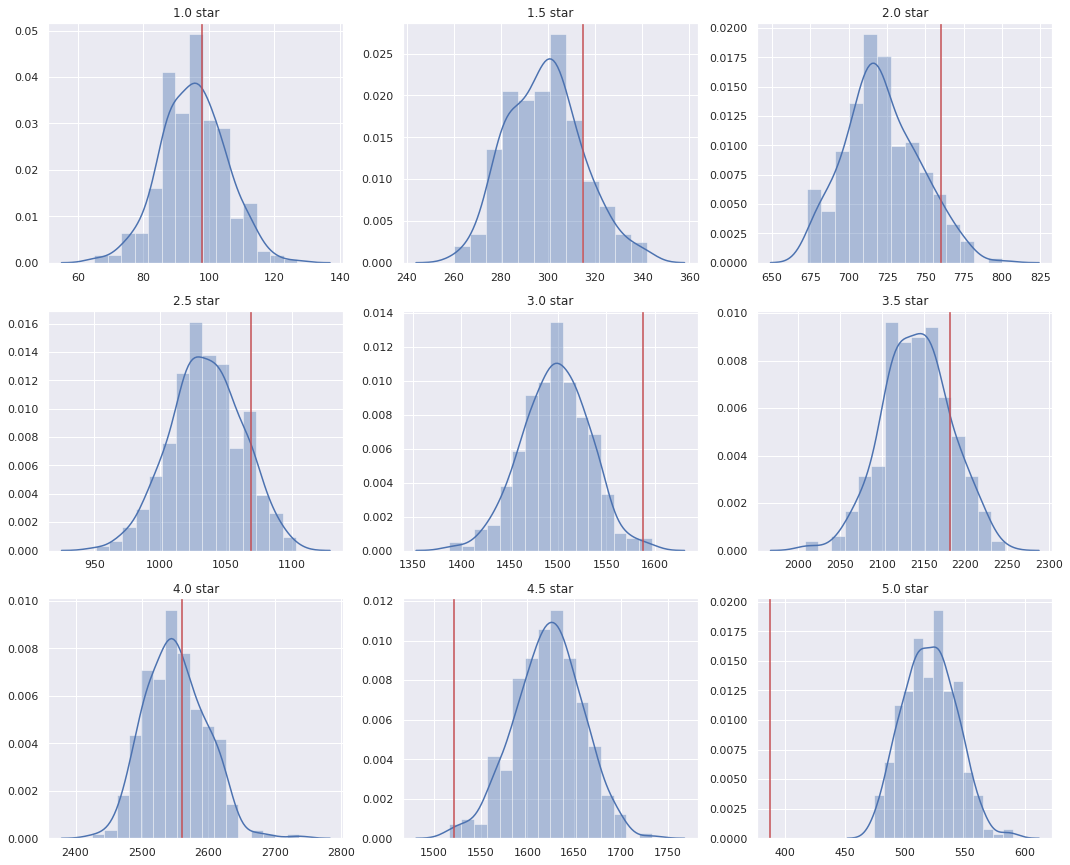

In [14]:
plot_count_dist(marginal_svi,train_ratings,"ddd","d",mode="dhd",is_cuda = True)

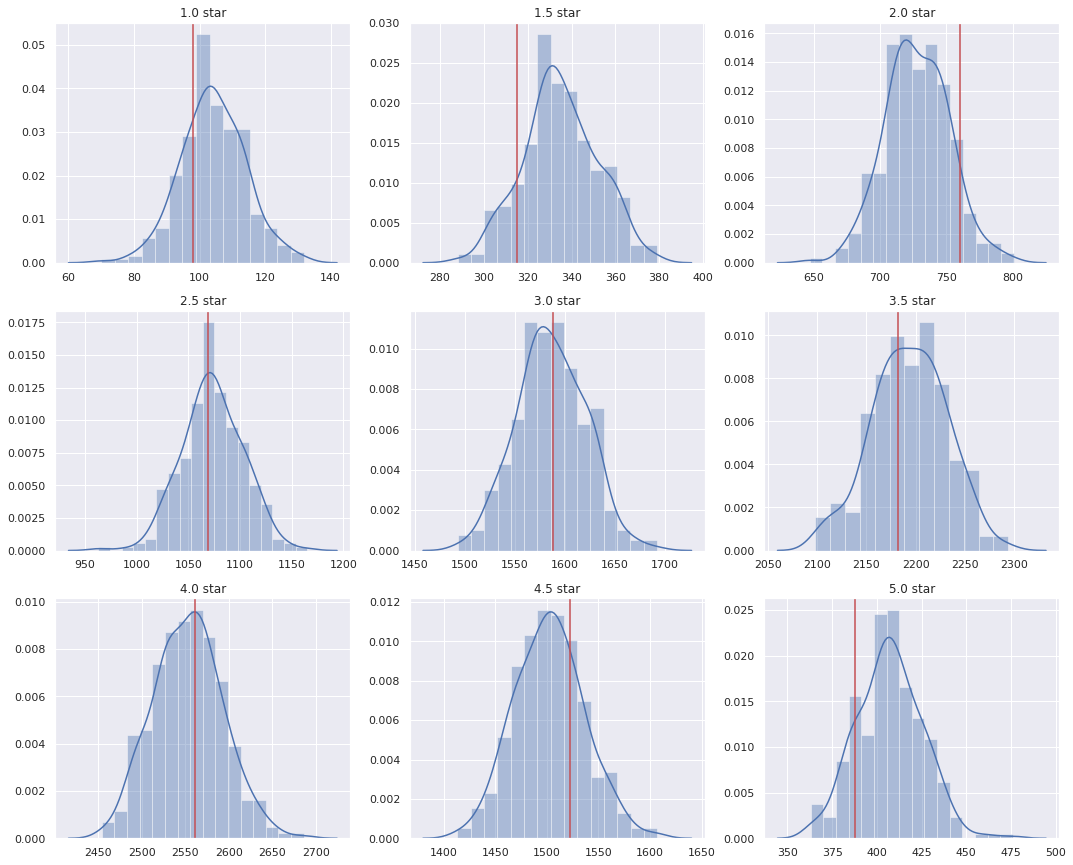

In [12]:
plot_count_dist(marginal_mcmc,train_ratings,"ddd","d",mode="dhd",is_cuda = True)

In [ ]:
#Poisson
pois = Pois()
pois_ratings = pois.process_ratings(ratings)

In [ ]:
post_svi, loss = svi(data, pois_ratings, pois.model, pois.guide, 10000)

In [ ]:
samples = svi_sampling(post_svi, data, ratings, pois.model, "Pois")

In [ ]:
from pyro.infer.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(pois.model)

NameError: name 'pois' is not defined

In [ ]:
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi_model = SVI(pois.model, 
                guide, 
                optim.Adam({"lr": .005}), 
                loss=elbo, 
                num_samples=500)

pyro.clear_param_store()
loss_list = []
for i in range(10000):
    ELBO = svi_model.step(data, pois_ratings)
    if i % 500 == 0:
        print(ELBO)
        loss_list.append(ELBO)



In [ ]:
res = svi_sampling(svi_model, data, pois_ratings, pois.model, "Pois")

In [ ]:
mode_res = res.copy()

In [ ]:
mode_res[res> 10] = 10

In [ ]:
avg_mode_res = np.average(np.squeeze(mode_res),axis = 0)

(array([7.800e+02, 4.631e+03, 3.456e+03, 1.341e+03, 4.310e+02, 1.160e+02,
        2.400e+01, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([0.98     , 1.1658   , 1.3516   , 1.5374   , 1.7232001, 1.909    ,
        2.0948   , 2.2806   , 2.4664001, 2.6522   , 2.838    ],
       dtype=float32),
 <a list of 10 Patch objects>)

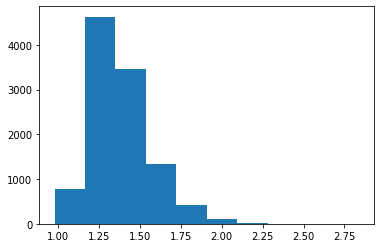

In [ ]:
plt.hist(avg_mode_res)

In [ ]:
# for mlr
mlrmodel = MlrModel()
# model = mlrmodel.model(data,train_ratings)

In [5]:
######## new mcmc ########
mlr_mcmc = inference.mcmc(data,train_ratings,mlrmodel.model,"mlr",mode="save")
hmc_beta_dict = criticism.mcmc_posterior(mlr_mcmc,data,train_ratings,"mlr",mode="save")

Warmup:   0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
res = np.zeros([1,3])
count = 0
for k,w in hmc_beta_dict.items():
  for i in range(w.shape[1]):
    temp_1 = np.ones([w.shape[0],1]) * i
    temp_3 = np.ones([w.shape[0],1]) * count
    temp_2 = np.expand_dims(w[:,i],axis =1)
    tmp_res = np.concatenate([temp_1,temp_2,temp_3],axis = 1)
    res = np.concatenate([res,tmp_res], axis = 0)
  count += 1
res = res[1:]

In [ ]:
df_beta = pd.DataFrame(res, columns = ["ha1","ha2","ha3"])

In [39]:
df_beta

,ha1,ha2,ha3
0,0.0,1.388054,0.0
1,0.0,1.388071,0.0
2,0.0,1.389874,0.0
3,0.0,1.388945,0.0
4,0.0,1.387713,0.0
...,...,...,...
580795,241.0,0.652849,7.0
580796,241.0,0.652179,7.0
580797,241.0,0.651809,7.0
580798,241.0,0.650097,7.0


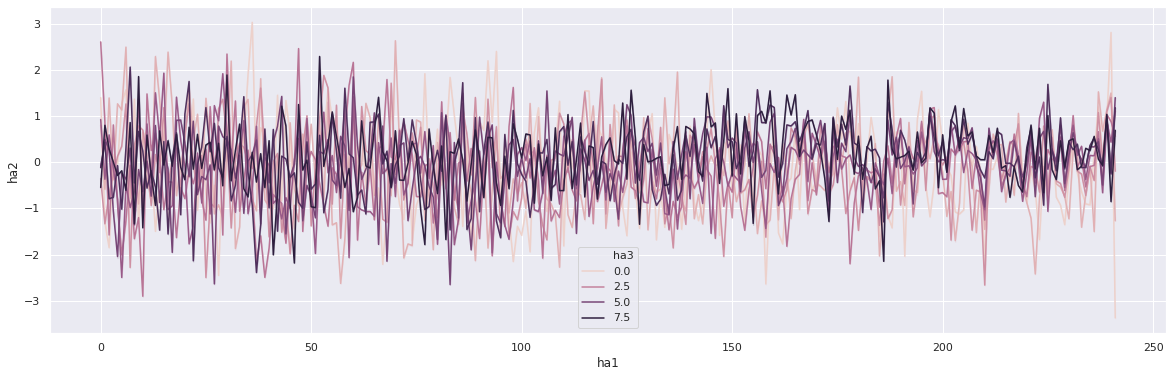

In [41]:
plt.subplots(figsize=(20, 6))
ax = sns.lineplot(x="ha1", y="ha2", hue="ha3", data=df_beta)

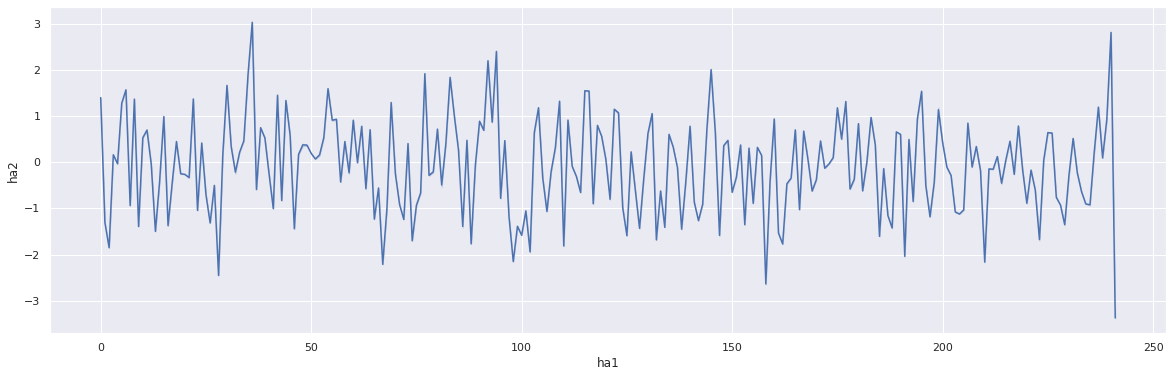

In [43]:
plt.subplots(figsize=(20, 6))
ax = sns.lineplot(x="ha1", y="ha2", data=df_beta[df_beta["ha3"] == 0])

In [ ]:
hmc_beta_dict = load("mlr_mcmc_beta_dict")

In [ ]:
tensor_beta = {k:torch.from_numpy(v).cuda() for k,v in hmc_beta_dict.items()}

In [ ]:
 mlr_mcmc_sample = criticism.mlr_mcmc_sampling(tensor_beta, data, mode="save", is_cuda = True)

In [ ]:
mlr_mcmc_sample_np = mlr_mcmc_sample.detach().cpu().numpy()
train_ratings_np = train_ratings.detach().cpu().numpy()

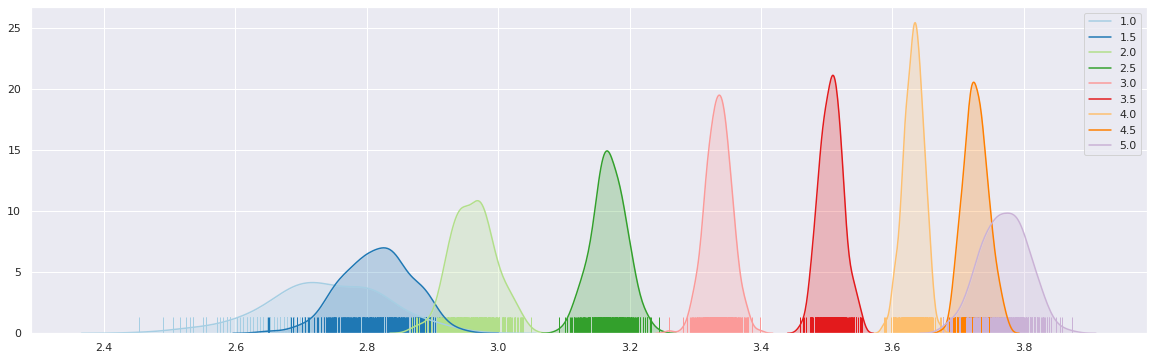

In [19]:
plot_rating_dist(mlr_mcmc_sample_np,train_ratings_np)

In [ ]:
######## load mcmc ########
mlr_mcmc = load("data_pickle/mlr_hmc")
hmc_beta_dict = load("data_pickle/mlr_hmc_beta_dict")
mlr_mcmc_sample = criticism.mlr_mcmc_sampling(hmc_beta_dict, data, mode="save")

In [ ]:

# # run mcmc
# #hmc_beta_dict = mlrmodel.mcmc(data,ratings,mlrmodel.model,mode="save")
# # load mcmc
# hmc_beta_dict = load("hmc_m_logis_10000")
# # run test samples
# test_samples = mlrmodel.test(hmc_beta_dict,data[:10000],mode="save")
# # load test samples
# #test_samples = load("mlr_test_samples")

In [ ]:
mlrmodel = MlrModel()
from pyro.infer.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(mlrmodel.model)
mlr_svi_model, mlr_loss_list = inference.svi(data, train_ratings, mlrmodel.model, mlrmodel.guide,10000)

In [9]:
mlr_svi_model, mlr_loss_list = inference.svi(data, train_ratings, mlrmodel.model, mlrmodel.guide,10000)

153759.578125


/usr/local/lib/python3.6/dist-packages/pyro/infer/traceenum_elbo.py:475: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


nan


KeyboardInterrupt: ignored

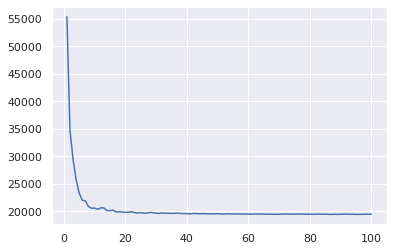

In [10]:
plot_loss(mlr_loss_list)

In [1]:
data.shape

NameError: ignored

In [10]:
moya = criticism.svi_sampling(mlr_svi_model, data, train_ratings, mlrmodel.model, "mlr", mode="save")

FileNotFoundError: ignored

In [ ]:
# samples_np = samples.detach().cpu().numpy()

train_ratings_np = train_ratings.detach().cpu().numpy()

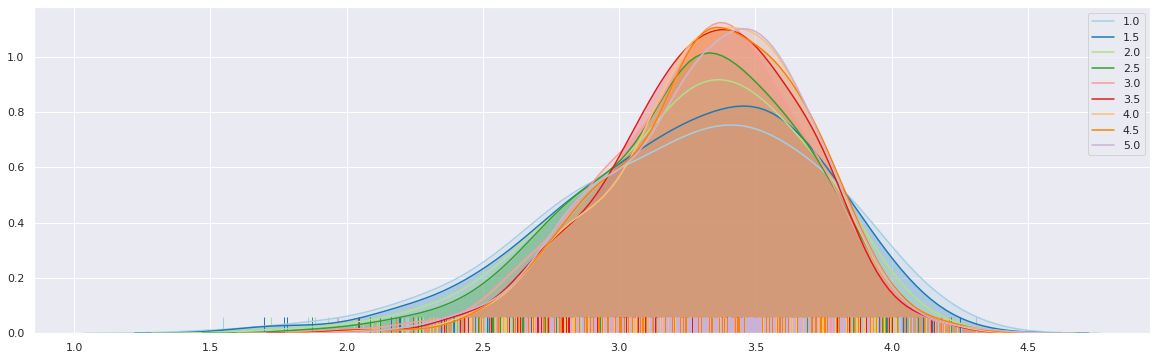

In [14]:
plot_rating_dist(marginal,train_ratings_np)

In [ ]:

res = np.zeros([1,3])
count = 0
for k,w in svi_samples.items():
  for i in range(w.shape[1]):
    temp_1 = np.ones([w.shape[0],1]) * i
    temp_3 = np.ones([w.shape[0],1]) * count
    temp_2 = np.expand_dims(w[:,i],axis =1)
    tmp_res = np.concatenate([temp_1,temp_2,temp_3],axis = 1)
    res = np.concatenate([res,tmp_res], axis = 0)
  count += 1
res = res[1:]

In [ ]:

df_beta = pd.DataFrame(res, columns = ["ha1","ha2","ha3"])

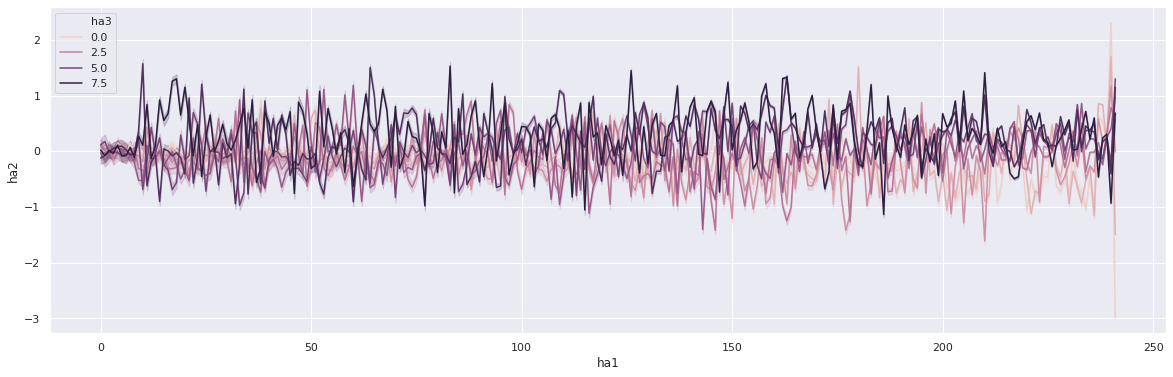

In [17]:
plt.subplots(figsize=(20, 6))
ax = sns.lineplot(x="ha1", y="ha2", hue="ha3", data=df_beta,estimator=None)

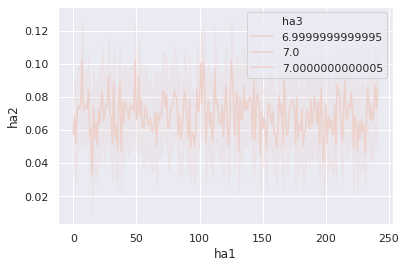

In [16]:
ax = sns.lineplot(x="ha1", y="ha2", hue="ha3", data=df_beta[df_beta['ha3'] == 7])

In [20]:
svi_samples['beta_1'].shape

(500, 242)

In [ ]:
svi_model = mlr_svi_model
model = mlrmodel.model
model_type ="mlr"
mode="save"
def wrapped_model(data, train_ratings):
    pyro.sample("prediction", dist.Delta(model(data, train_ratings)))

posterior = svi_model.run(data, train_ratings)
sites = ["beta_1","beta_1h","beta_2","beta_2h","beta_3","beta_3h","beta_4","beta_4h"]

svi_samples = {site: EmpiricalMarginal(posterior, sites=site).
               enumerate_support().detach().cpu().numpy() 
               for site in sites}



get_marginal = lambda traces, sites:EmpiricalMarginal(traces, sites) \
               ._get_samples_and_weights()[0].detach().cpu().numpy()

trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=300)
post_pred = trace_pred.run(data, None)
marginal = get_marginal(post_pred, ["obs"])
# if mode == "save":
# #     to_pickle(marginal,"data_pickle/{}/{}_svi_samples".format(model_type, model_type))
# #     to_pickle(svi_samples,"data_pickle/{}/{}_svi_beta_dict".format(model_type, model_type))


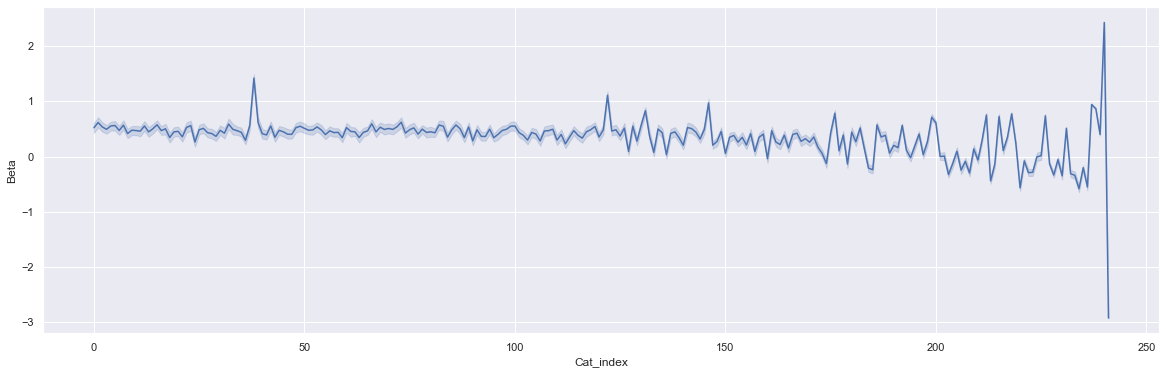

In [ ]:
plt.subplots(figsize=(20, 6))
ax = sns.lineplot(x="Cat_index", y="Beta", data=df_beta_1)

In [ ]:

df_beta_2 = pd.DataFrame(columns=['Cat_index','Beta'])
for s in svi_samples['beta_2']:
    for i in range(svi_samples['beta_2'].shape[1]):
        df_beta_2 = df_beta_2.append({'Cat_index': i,'Beta':s[i]},ignore_index=True)

KeyboardInterrupt: 

In [ ]:
plt.subplots(figsize=(20, 6))
ax = sns.lineplot(x="Cat_index", y="Beta", data=df_beta_2)

In [ ]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats




In [ ]:
summary(samples)

AttributeError: 'numpy.ndarray' object has no attribute 'items'

In [ ]:
for site, values in summary(svi_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: beta_1
         mean       std        5%       25%       50%       75%       95%
0    1.268482  0.964982 -0.190790  0.587419  1.251281  1.903326  2.906853
1    0.382928  1.011312 -1.184087 -0.312992  0.354495  1.103957  2.110493
2    0.446522  0.973771 -1.102764 -0.181372  0.396788  1.048008  2.064686
3    0.276709  0.986592 -1.330498 -0.392535  0.257006  0.948982  1.980749
4    0.388821  0.952195 -1.175261 -0.267510  0.405343  1.107426  1.826193
5    0.272013  0.979857 -1.319092 -0.369016  0.313132  0.942086  1.842825
6    0.541504  1.015740 -1.225175 -0.093403  0.541990  1.222994  2.265665
7    0.732782  0.932556 -0.821894  0.163792  0.706401  1.328274  2.192020
8    0.616997  0.964268 -0.952065 -0.059559  0.656000  1.283395  2.095534
9    0.254603  1.000462 -1.399466 -0.443699  0.259883  0.949903  1.842069
10   0.169547  0.981800 -1.465505 -0.530076  0.173022  0.872649  1.739491
11   0.044143  0.937737 -1.521673 -0.576891  0.090936  0.707255  1.628651
12   0.279377  1.012691 -

In [ ]:

rating_index_dict = dict()
for r in range(9):
    rating_index_dict[r] = np.squeeze(np.argwhere(train_ratings==r))

In [ ]:
samples

array([[7, 1, 0, ..., 2, 5, 4],
       [1, 4, 1, ..., 1, 6, 6],
       [2, 7, 1, ..., 2, 5, 0],
       ...,
       [1, 1, 2, ..., 1, 1, 1],
       [7, 7, 0, ..., 7, 1, 0],
       [4, 3, 2, ..., 0, 5, 3]])

In [ ]:
samples

array([6., 7., 4., ..., 6., 3., 7.], dtype=float32)

In [ ]:
for i in range(500):
    corr = [samples[i][j]==train_ratings.numpy()[j] for j in range(samples.shape[1])]
    print(sum(corr)/len(corr))

0.11771439473433178
0.07812649050844224
0.10111609272154917
0.10226080320518935
0.10168844796336926
0.09348468949728131
0.08499475341028331
0.03634455785557569
0.10674425259944673
0.10378708385004293
0.09901745683487552
0.10483640179337976
0.11265859009825431
0.11275398263855767
0.1392731088428885
0.1222932366688925
0.06047887055232281
0.09930363445578556
0.11857292759706191
0.12334255461222933
0.09396165219879805
0.09005055804636078
0.13202327577983403
0.11761900219402843
0.11036916913097396
0.07345225603357818
0.11790517981493848
0.06458074978536678
0.0719259753887246
0.08089287417723934
0.1221024515882858
0.10388247639034627
0.09815892397214537
0.08633024897453019
0.11714203949251169
0.07163979776781455
0.14843079271200993
0.08327768768482305
0.12286559191071258
0.10655346751884003
0.13726986549651818
0.10636268243823332
0.10865210340551369
0.06868262901841075
0.08346847276542975
0.04731469999046074
0.11399408566250119
0.12849375178861014
0.09386625965849471
0.09224458647333779
0.11

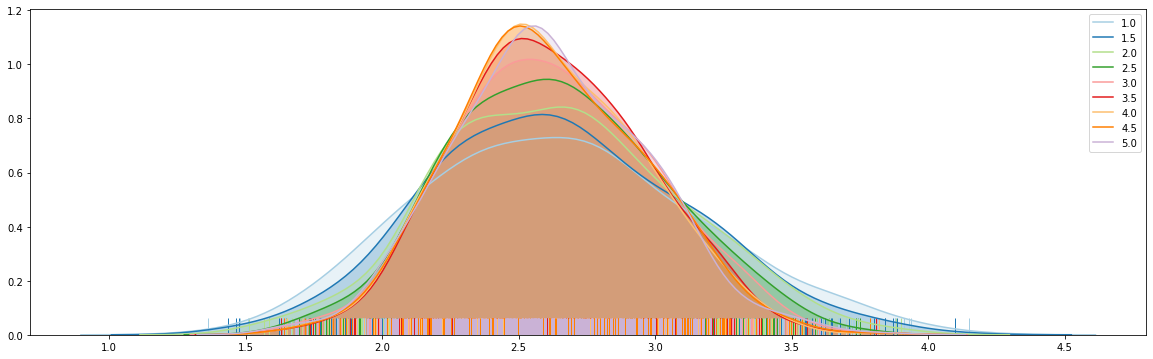

In [ ]:
plt.subplots(figsize=(20, 6))
color = sns.color_palette("Paired")
samples = np.squeeze(marginal)
for i in range(9):
    #d = data[sample_dict[s]]
    sample_data = samples[:,rating_index_dict[i]]
    sample_data_in_star = sample_data/2 + 1
    sample_data_ave = np.average(sample_data_in_star,axis=1)
    #print(sample_data_ave)
    sns.distplot(sample_data_ave,label="{}".format(i/2+1),rug=True, hist=False,kde_kws={"shade": True},color=color[i])

In [ ]:
# sample_data = samples[:,sample_dict[5]]/2+1

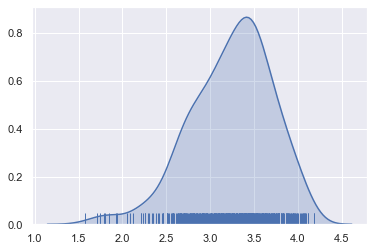

In [ ]:
# sns.distplot(sample_ave,rug=True, hist=False,kde_kws={"shade": True})

In [ ]:
# samples = load("mlr_test_samples")

In [ ]:
mcmc_samples = mcmc_samples.numpy()

In [ ]:
to_pickle(sample_dict,"mlr_mcmc_sample_count_dict")

In [ ]:

sample_dict = dict()
for r in range(9):
    sample_dict[r]=[]

for i in range(samples.shape[0]):
    print(i)
    for j in range(9):
        sample_dict[j].append(len([ k for k in samples[i] if k == j]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

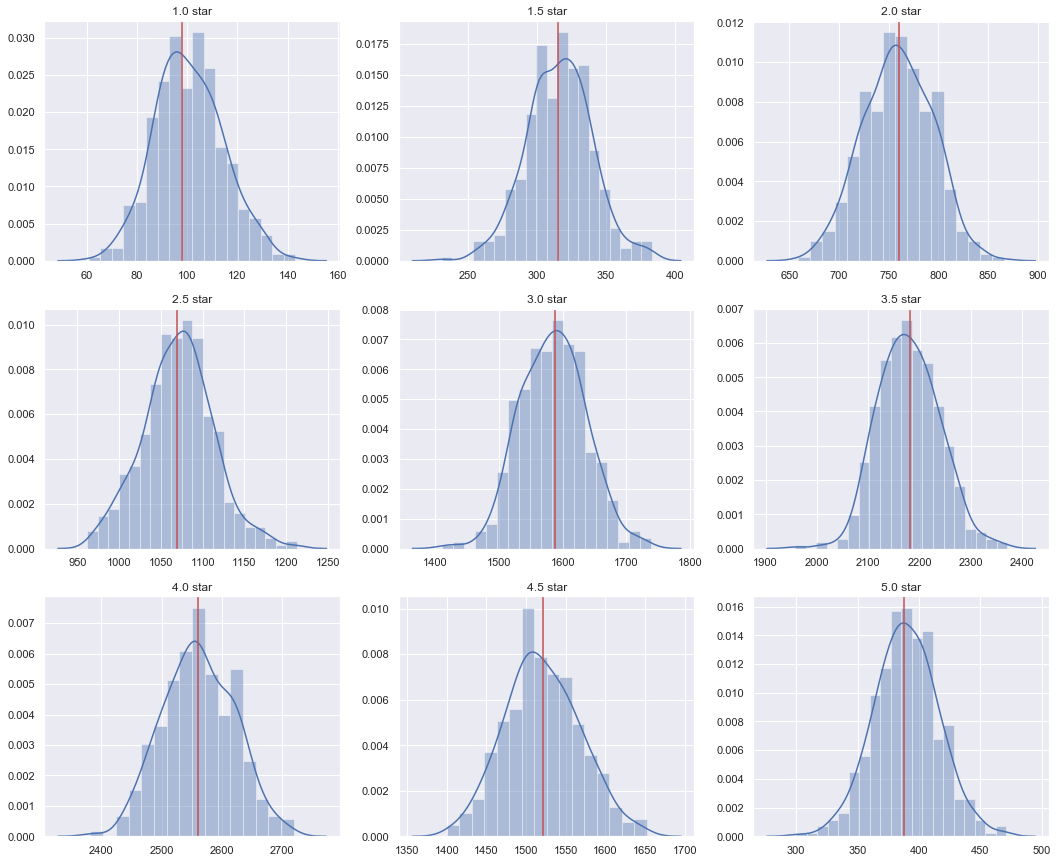

In [ ]:

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))
for i, ax in enumerate(axs.reshape(-1)):
#     star = rating_cat[i]
    sns.distplot(sample_dict[i],ax=ax)
    ax.axvline(len([ k for k in train_ratings if k == i ]), 0,1,color='r')
    ax.set_title("{} star".format(i/2+1))

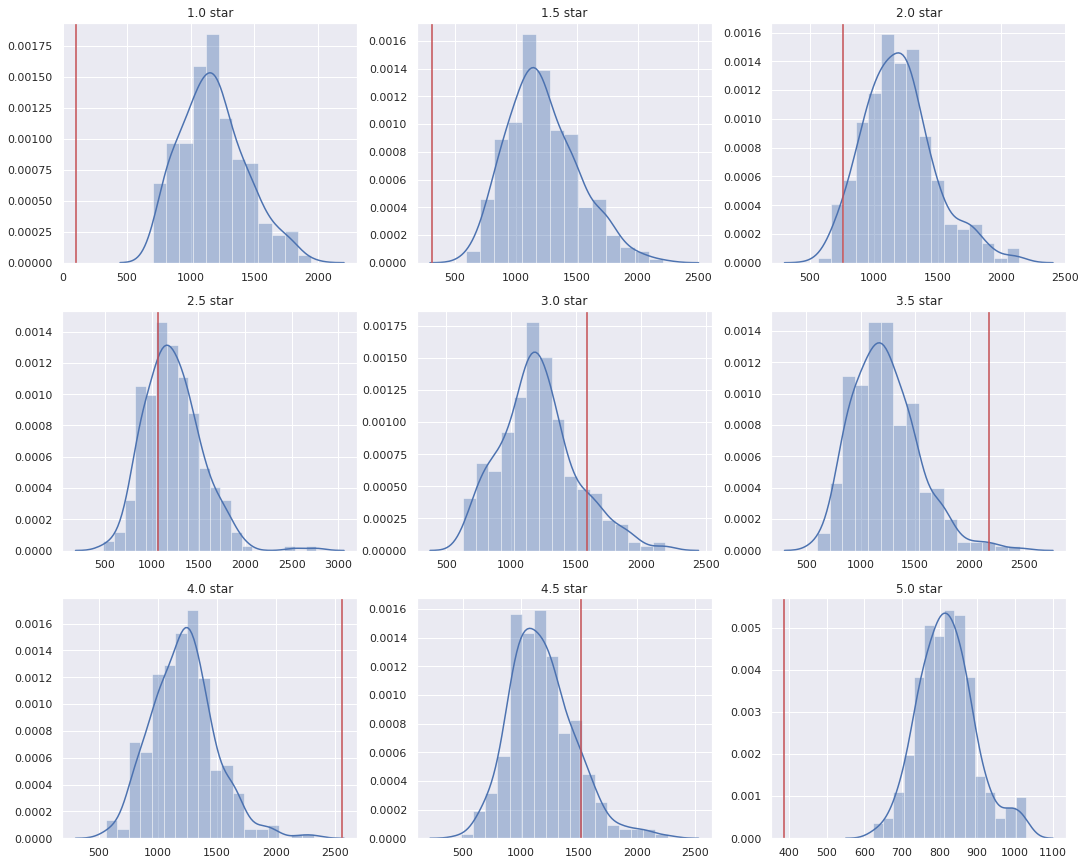

In [20]:
plot_count_dist(marginal,train_ratings,"ddd","ddd","nosave")

In [ ]:
rating_cat = [1,1.5,2,2.5,3,3.5,4,4.5,5]
sample_dict = dict()
for r in rating_cat:
    sample_dict[r]=[]

for i in range(samples.shape[0]):
    for index,r in enumerate(rating_cat):
        sample_dict[r].append(len([ k for k in samples[i] if k == index]))

In [ ]:
# res = samples
# desc = np.ones([res.shape[0],9])

# for i in range(res.shape[0]):
#     for j in range(9):
#         desc[i][j] = len(res[i][res[i] == j])


# true_num = np.ones(9)
# to_process = ratings * 2
# for i in range(9):
#     true_num[i] = len(to_process[to_process == i + 2])

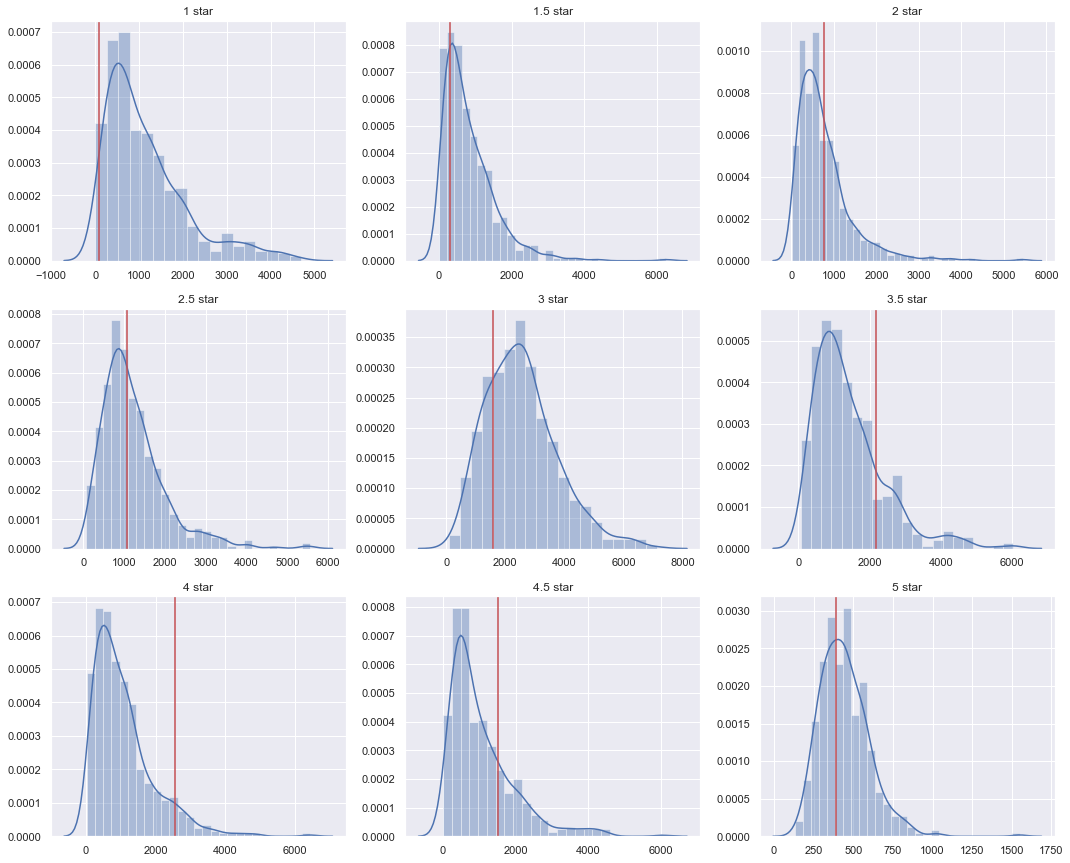

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))
for i, ax in enumerate(axs.reshape(-1)):
    star = rating_cat[i]
    sns.distplot(sample_dict[star],ax=ax)
    ax.axvline(len([ k for k in ratings if k == star ]), 0,1,color='r')
    ax.set_title("{} star".format(star))

In [ ]:

optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

In [ ]:
np.average(ratings)

3.4529238

In [ ]:
rating_bi = ratings >= np.average(ratings)

In [ ]:
rating_bi

tensor([ True,  True, False,  ...,  True, False,  True])

In [10]:
def model(data, rating_bi):
    #make one-hot vector length betas

    mu = torch.rand(data.shape[1],dtype=torch.float)
    sigma = 1
    with pyro.plate("betas", data.shape[1]):
        beta = pyro.sample("beta", dist.Normal(mu, sigma))
        
        
    p = torch.sum(beta * data,axis=1)
    
    p_exp = 1 / (1+torch.exp(-p))

    with pyro.plate("ratings", data.shape[0]):
        y = pyro.sample("obs", dist.Bernoulli(logits=p_exp), obs = rating_bi)
    return y

In [ ]:
from pyro.infer.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(model)
svi_model, loss_list = inference.svi(data, rating_bi, model, guide,10000)

RuntimeError: Subtraction, the `-` operator, with two bool tensors is not supported. Use the `^` or `logical_xor()` operator instead.

In [24]:
def model(data, train_ratings):
    #make one-hot vector length betas

    mu = torch.rand(data.shape[1],dtype=torch.float)
    sigma = 1
    with pyro.plate("betas", data.shape[1]):
        beta = pyro.sample("beta", dist.Normal(mu, sigma))
        
        
    p = torch.sum(beta * data,axis=1)
    
    p_exp = 1 / (1+torch.exp(-p))

    with pyro.plate("ratings", data.shape[0]):
        y = pyro.sample("obs", dist.Binomial(8,probs=p_exp), obs = train_ratings)
    return y

In [25]:
    
def guide(data, ratings):
    sigma = pyro.param('sigma', torch.rand(data.shape[1]),  constraint=constraints.positive)
#         mu = pyro.param('mu', torch.zeros(data.shape[1]))     

    #mu = pyro.param('mu', torch.rand(data.shape[1]))        
    mu = pyro.param('mu', torch.rand(data.shape[1],dtype=torch.float))


    with pyro.plate("betas", data.shape[1]):
        beta = pyro.sample("beta", dist.Normal(mu, sigma))
            
        

In [26]:
#from pyro.infer.autoguide import AutoDiagonalNormal
#guide = AutoDiagonalNormal(model)
svi_model, loss_list = svi(data, train_ratings, model, guide,10000,"bi",False,True)

74199.8046875
20619.896484375
19701.05078125
19328.10546875
19341.134765625
19345.0625
19207.916015625
19033.498046875
18987.830078125
19039.34375
19003.486328125
18986.298828125
18971.2109375
18975.80078125
18991.13671875
18977.087890625
18968.365234375
18973.46484375
18982.9921875
18972.82421875


In [27]:
def wrapped_model(data, train_ratings):
    pyro.sample("prediction", dist.Delta(model(data, train_ratings)))
   

posterior = svi_model.run(data, train_ratings)
sites = ["beta"]

svi_betas = {site: EmpiricalMarginal(posterior, sites=site).
               enumerate_support().detach().cpu().numpy() 
               for site in sites}


In [33]:
svi_betas['beta']

array([[-2.6100051e-01, -4.2246872e-01,  1.8528694e+00, ...,
        -9.3076127e-03, -5.3527153e-01,  4.2666379e-01],
       [-1.5740721e+00,  2.5059853e+00,  7.6301205e-01, ...,
         4.5801323e-02, -5.8735067e-01,  4.2461699e-01],
       [ 1.7568895e-01,  1.0858622e+00, -2.8878751e-01, ...,
         1.4873480e-02, -5.5089021e-01,  4.2749426e-01],
       ...,
       [-3.3943355e-02,  3.7400866e-01,  1.2156329e+00, ...,
         1.7768763e-02, -5.5514008e-01,  4.2360938e-01],
       [-1.6448706e-01, -1.1922616e+00,  6.1905503e-01, ...,
         1.9844049e-03, -5.6454617e-01,  4.1828001e-01],
       [ 5.1201719e-01,  8.7951547e-01,  1.0080079e+00, ...,
         1.1813084e-02, -5.6050211e-01,  4.4690648e-01]], dtype=float32)

In [36]:
p = torch.matmul(torch.from_numpy(svi_betas['beta']),data.T)

In [40]:

p_exp = 1 / (1+torch.exp(-p))
    
   
mci = p_exp.mean(axis = 0)
initial = True
for i in range(300):
    if initial:
        initial = False
        y = torch.unsqueeze(pyro.sample("obs", dist.Binomial(8,mci)),axis = 0)
    else:
        y = torch.cat([y, torch.unsqueeze(pyro.sample("obs", dist.Binomial(8,mci)),axis = 0)],axis=0)


In [41]:
y

tensor([[6., 6., 3.,  ..., 6., 6., 6.],
        [4., 6., 5.,  ..., 3., 6., 8.],
        [5., 2., 5.,  ..., 5., 8., 7.],
        ...,
        [6., 6., 5.,  ..., 5., 6., 7.],
        [3., 7., 4.,  ..., 3., 6., 7.],
        [2., 7., 7.,  ..., 6., 4., 8.]])

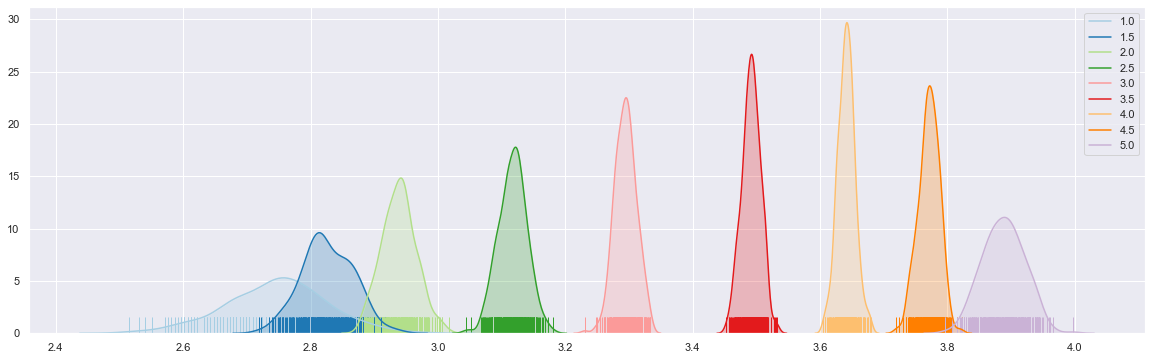

In [42]:

plot_rating_dist(y,train_ratings)

In [ ]:
nuts_kernel = NUTS(model)
hmc = MCMC(nuts_kernel, num_samples=50, warmup_steps=50)


In [ ]:
hmc.run(data,train_ratings)
hmc_beta_dict = {k: v.detach().cpu().numpy() for k, v in hmc.get_samples().items()}
    

sample: 100%|██████████| 100/100 [18:12<00:00, 10.93s/it, step size=1.49e-35, acc. prob=0.000]


In [ ]:
hmc_beta_dict['beta'].shape

(50, 242)

In [ ]:
p = torch.matmul(torch.from_numpy(hmc_beta_dict['beta']),data.T)

p_exp = 1 / (1+torch.exp(-p))

y = pyro.sample("obs", dist.Binomial(8,logits=p_exp))



In [ ]:
y.max()

tensor(8.)

In [ ]:
# for i in range(500):
#     corr = [samples[i][j]==train_ratings.numpy()[j] for j in range(samples.shape[1])]
#     print(sum(corr)/len(corr))

0.16378899170084898
0.14967089573595344
0.17037107698178003
0.15720690641991797
0.15453591529142421
0.16197653343508536
0.15587141085567108
0.1590193646856816
0.16312124391872557
0.12057617094343222
0.1691309739578365
0.159687112467805
0.13679290279500142
0.1396546790041019
0.1392731088428885
0.16512448726509588
0.15005246589716684
0.1560621959362778
0.13326337880377753
0.1604502527902318
0.13955928646379853
0.15959171992750168
0.16407516932175903
0.16235810359629876
0.1396546790041019
0.1632166364590289
0.15539444815415435
0.17514070399694745
0.1554898406944577
0.17084803968329676
0.16350281407993894
0.09958981207669561
0.14862157779261662
0.1606410378708385
0.15072021367929028
0.17342363827148716
0.1331679862634742
0.153105027186874
0.15596680339597443
0.14986168081656015
0.16388438424115234
0.1351712296098445
0.16903558141753314
0.1578746542020414
0.1373652580368215
0.16369359916054566
0.15701612133931125
0.14738147476867308
0.159687112467805
0.14556901650290946
0.14614137174472958


IndexError: index 100 is out of bounds for axis 0 with size 100

In [ ]:
sample_data = samples[:,rating_index_dict[8]]
sample_data

tensor([[8., 6., 5.,  ..., 6., 4., 7.],
        [8., 6., 5.,  ..., 7., 7., 8.],
        [5., 7., 6.,  ..., 4., 7., 4.],
        ...,
        [7., 7., 6.,  ..., 5., 5., 4.],
        [5., 6., 7.,  ..., 4., 5., 6.],
        [5., 5., 6.,  ..., 8., 4., 5.]])

In [ ]:
sample_data_ave = np.average((samples[:,rating_index_dict[0]]/2+1),axis=1)
minmin = sample_data_ave.max()
minmin

3.2142856

In [ ]:
sample_data_ave = np.average((sample_data/2+1),axis=1)
maxmax = sample_data_ave.max()
maxmax

3.8621135

In [ ]:

sample_data_ave = np.average((samples[:,rating_index_dict[4]]/2+1),axis=1)
sample_data_ave = 4 * (sample_data_ave-minmin)/(maxmax-minmin) + 1
sample_data_ave

array([2.175074 , 1.984552 , 2.2159   , 2.1148057, 2.233396 , 2.2742238,
       2.0487065, 2.1770172, 2.2645018, 2.138136 , 2.2256205, 2.1498008,
       2.126471 , 2.5638952, 2.2936645, 2.3092172, 2.1809065, 2.070092 ,
       2.365596 , 2.18285  , 2.313105 , 2.3714285, 2.276167 , 2.342266 ,
       2.1575766, 2.1711848, 2.159521 , 2.1089735, 2.247006 , 2.3189375,
       2.0778675, 2.2217326, 2.1867375, 2.2392287, 2.1459117, 2.429752 ,
       2.2061796, 2.3597636, 2.1886823, 2.4861312, 2.2956076, 2.18285  ,
       2.1459117, 2.1361914, 2.1789618, 2.1245263, 2.3228254, 2.231453 ,
       2.0292659, 2.2742238], dtype=float32)

In [ ]:
sample_data 

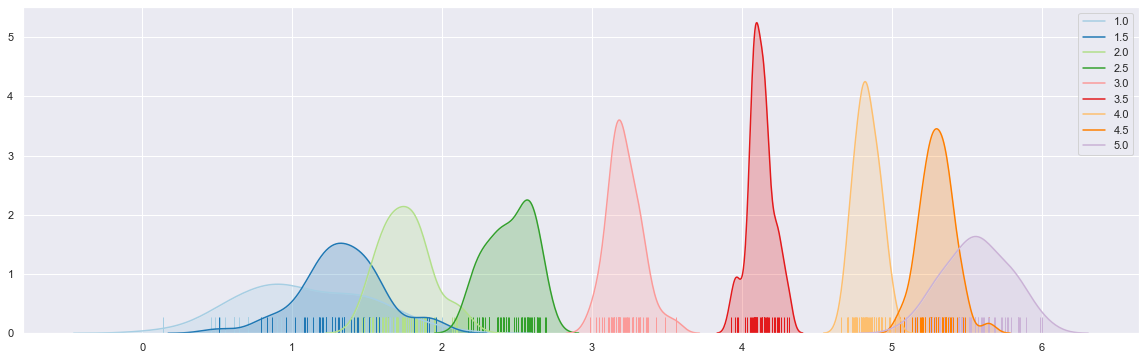

In [ ]:
plt.subplots(figsize=(20, 6))
color = sns.color_palette("Paired")
samples = y
for i in range(9):
    #d = data[sample_dict[s]]
    sample_data = samples[:,rating_index_dict[i]]
#     sample_data_in_star = sample_data/2 + 1
    sample_data_ave = np.average(sample_data/2+1,axis=1)
    sample_data_ave = 4 * (sample_data_ave-minmin)/(maxmax-minmin) + 2
    sns.distplot(sample_data_ave,label="{}".format(i/2+1),rug=True, hist=False,kde_kws={"shade": True},color=color[i])

In [19]:
beta_dict = load('mlr_mcmc_beta_dict')
beta_1 = np.average(beta_dict['beta_1'],axis = 1)
beta_1.shape

(300,)

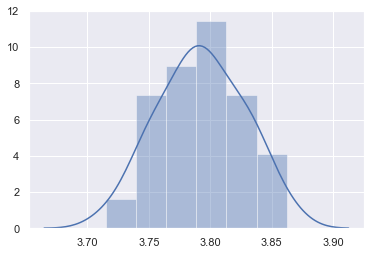

In [ ]:
sns.distplot(sample_data_ave)